In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from matplotlib import colors
from Jworkflow.plot import plot_slab
from pymatgen.core import Structure

In [22]:
def Gradient_Graphics6(p1_axes,p2_x,p3_y,p4_edge=['k',3],p5_colormap=[(0,'r'),(1,'w')],p6_color_matrix=[[0],[1]],p7_close_patch=False,p8_alpha=1,p9_zorder=666):
    cmap=colors.LinearSegmentedColormap.from_list('Cmap',p5_colormap,N=256)
    x=list(p2_x);y=list(p3_y)
    if p7_close_patch:
        x.append(x[0])
        y.append(y[0])
    x=np.array(x)
    y=np.array(y)
    print(x.shape,y.shape)
    path=Path(np.array([x,y],dtype=object).transpose())
    patch=PathPatch(path,facecolor='none',edgecolor=p4_edge[0],lw=p4_edge[1],zorder=p9_zorder+1)
    p1_axes.add_patch(patch)
    p1_axes.imshow(p6_color_matrix,interpolation="bicubic",origin='lower',aspect="auto",clip_path=patch,clip_on=True,
              alpha=p8_alpha,cmap=cmap,extent=[min(p2_x),max(p2_x),min(p3_y),max(p3_y)],zorder=p9_zorder)
    
def num_to_subscript(x1_str):
    # 用于将一个字符串里的数字转化为下标，返回一个可用于matplotlib的text的格式
    mtext=''
    for s in x1_str:
        if s.isdigit() and int(s)==1:continue
        elif s.isdigit() : add='$_{'+s+'}$';mtext+=add
        else : mtext+=s      #if s.isalpha() : mtext+=s
    #mtext+='$'
    return(mtext)

In [20]:
def energy_diagram(ax, df, sys, path_steps, first_color='k',interval=1, lp_step=[1.2,'-'], lp_inter=[0.6,'--'], xtickpara=['N2(g)',7,-30,'left',[]],
                  xylim=None):
    x_labels=[]
    # initial 0 step
    x_start=0
    ax.plot([x_start,x_start+1],[0,0],lw=lp_step[0],ls=lp_step[1],c=first_color,zorder=66)
    x_labels.append(x_start+0.5)
    x_start+=1
    y_ends=[0]
    # loop and plot step
    for path_step in path_steps:
        for i,adsb in enumerate(path_step[0]):
            energy=df.at[sys, adsb[0]]
            for connection in path_step[1][i]:
                y_start=y_ends[connection[0]]
                ax.plot([x_start,x_start+interval],[y_start,energy],lw=lp_inter[0],ls=lp_inter[1],c=connection[1],zorder=36)
            x_start+=interval
            ax.plot([x_start,x_start+1],[energy,energy],lw=lp_step[0],ls=lp_step[1],c=adsb[1],zorder=66)
            x_start+=-1*interval
        y_ends=[df.at[sys,iadsb[0]] for iadsb in path_step[0]]
        x_start+=1+interval
        x_labels.append(x_start-0.5)
        
    ax.set_xticks(x_labels)
    if xtickpara:
        xticklabels=[xtickpara[0]]+['/'.join([num_to_subscript(iadsb[0]) for iadsb in path_step[0] if iadsb[0] not in xtickpara[-1]]) for path_step in path_steps]
        ax.set_xticklabels(xticklabels,fontsize=xtickpara[1],rotation=xtickpara[2],ha=xtickpara[3])
    else:
        ax.set_xticks([])
    if xylim:
        ax.set_xlim([xylim[0],xylim[1]])
        ax.set_ylim([xylim[2],xylim[3]])

In [24]:
df=pd.read_excel(r'path_step_all.xlsx',index_col=0)
dfa=pd.read_excel(r'path_adss_all.xlsx',index_col=0)
dfv=pd.read_excel(r'step_validate.xlsx',index_col=0)
dff=pd.read_csv(r'feature.csv',index_col=0)
dfp=pd.read_excel(r'predict_all.xlsx',index_col=1)

for i in df.index:
    if df.at[i,'barrier']<0:
        df.at[i,'barrier']=0

# Figure 5b

In [4]:
ladsb1=[]
ladsb2=[]
ladsb3=[]
sele=[]
acti=[]
NH3r=[]
adsb=[]
for sys in df.index:
    adsb1=df.at[sys,'N2'] + dfp.at[dfa.at[sys,'N2'],'uq']
    adsb2=df.at[sys,'N2'] - df.at[sys,'H'] + dfp.at[dfa.at[sys,'N2'],'uq'] + dfp.at[dfa.at[sys,'H'],'uq']
    adsb3=df.at[sys,'NNH'] - df.at[sys,'H'] + dfp.at[dfa.at[sys,'NNH'],'uq'] + dfp.at[dfa.at[sys,'H'],'uq']
    ladsb1.append(adsb1);ladsb2.append(adsb2);ladsb3.append(adsb3)
    if adsb1 < 0 and adsb2 < 0 and adsb3 <0:
        adsb.append(True)
    else:
        adsb.append(False)
    
    if df.at[sys,'PDS']=='N2-NNH':
        uq_ac=dfp.at[dfa.at[sys,'N2'],'uq']+dfp.at[dfa.at[sys,'NNH'],'uq']
        ac=df.at[sys,'barrier']
    elif df.at[sys,'PDS']=='NH-NH2':
        uq_ac=dfp.at[dfa.at[sys,'NH'],'uq']+dfp.at[dfa.at[sys,'NH2'],'uq']
        ac=df.at[sys,'barrier']
    acti.append(ac+uq_ac)
    
    se=abs(df.at[sys,'H'])-abs(df.at[sys,'barrier'])-uq_ac-dfp.at[dfa.at[sys,'H'],'uq']
    sele.append(se)
    
    r3=-0.64 - df.at[sys,'NH2'] + 0.31955 + dfp.at[dfa.at[sys,'NH2'],'uq']
    NH3r.append(r3)

In [6]:
# lsys=[]
# lN2=[]
# lN2dH=[]
# lNNHdH=[]
# lPDS=[]
# lbar=[]
# lHdP=[]
# lNH3=[]
# for i in range(1134):
#     if sele[i] > 0.1 and acti[i] < 0.5 and adsb[i] and NH3r[i]<0.9 :
#         lsys.append(df.index[i])
#         lN2.append(ladsb1[i])
#         lN2dH.append(ladsb2[i])
#         lNNHdH.append(ladsb3[i])
#         lPDS.append(df.iloc[i]['PDS'])
#         lbar.append(df.iloc[i]['barrier'])
#         lHdP.append(sele[i])
#         lNH3.append(NH3r[i])
# dd={'system':lsys,'lN2':lN2,'lN2dH':lN2dH,'lNNHdH':lNNHdH,'lPDS':lPDS,'lbar':lbar,'lHdP':lHdP,'lNH3':lNH3}
# dfad=pd.DataFrame.from_dict(dd)
# dfad.to_excel(r'Table_SI_additionCanadiate.xlsx')

(7,) (7,)
(5,) (5,)


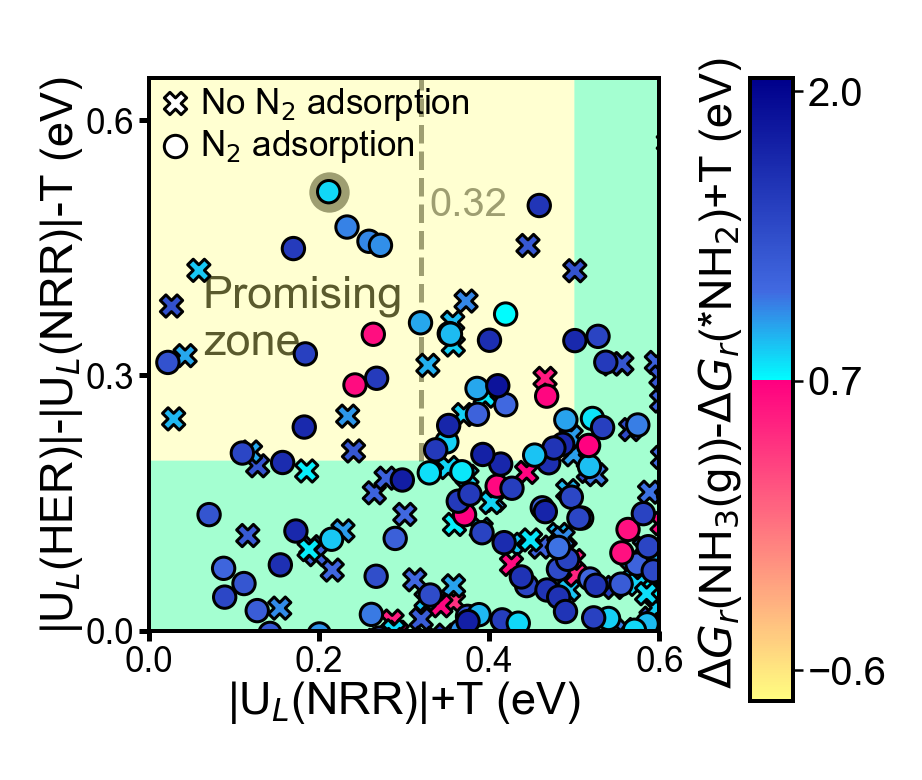

In [16]:
plt.rc('font',family='Arial')
fig=plt.figure(figsize=(6/2.54,5/2.54),dpi=360)

ax0=fig.add_axes([0,0,1,1])
ax0.set_xlim(0,1);ax0.set_ylim(0,1);ax0.set_xticks([]);ax0.set_yticks([]);ax0.axis('off')
ax0.patch.set_alpha(0.0)

ax1=fig.add_axes([0.133,0.16,0.6,0.78])
ax1.tick_params(length=2,width=1,labelsize=7,pad=1)
ax1.set_xlim([-0.0,0.6])
ax1.set_ylim([-0.,0.65])
ax1.set_xticks([0,0.2,0.4,0.6])
ax1.set_yticks([0,0.3,0.6])
ax1.set_xlabel('|U$_L$(NRR)|+T (eV)',fontsize=9,labelpad=0)
ax1.set_ylabel('|U$_L$(HER)|-|U$_L$(NRR)|-T (eV)',fontsize=9,labelpad=0)

acti_adsb=[acti[i] for i in range(len(adsb)) if adsb[i]] + [3,3]
sele_adsb=[sele[i] for i in range(len(adsb)) if adsb[i]] + [3,3]
NH3r_adsb=[NH3r[i] for i in range(len(adsb)) if adsb[i]] + [2.06,-0.74]
acti_Nadsb=[acti[i] for i in range(len(adsb)) if not adsb[i]] + [3,3]
sele_Nadsb=[sele[i] for i in range(len(adsb)) if not adsb[i]] + [3,3]
NH3r_Nadsb=[NH3r[i] for i in range(len(adsb)) if not adsb[i]] + [2.06,-0.74]

cmap=mpl.colors.LinearSegmentedColormap.from_list('count',[(0,'#ffff80'),(0.5142857142857143,'#ff0080'),(0.5142857142857144,'cyan'),(0.66,'royalblue'),(1,'darkblue')],N=256)
sc=ax1.scatter(acti_adsb,sele_adsb,c=NH3r_adsb,marker='o',s=20,zorder=2,lw=0.6,edgecolor='k',cmap=cmap)
ax1.scatter(acti_Nadsb,sele_Nadsb,c=NH3r_Nadsb,marker='X',s=20,zorder=1,lw=0.6,edgecolor='k',cmap=cmap)

axc=fig.add_axes([0.84,0.06,0.05,0.88])
cbar=plt.colorbar(sc,fraction=0.03,pad=0.03,orientation='vertical',cax=axc,ticks=[-0.6,0.7,2.0])
cbar.ax.tick_params(labelsize=8,length=2,width=0.5,pad=1)
ax0.text(0.776,0.06,'  $\Delta G_r$(NH$_3$(g))-$\Delta G_r$(*NH$_2$)+T (eV)',fontsize=9,rotation=90)

ax1.scatter(0.03,0.57,marker='o',s=20,lw=0.6,ec='k',c='w')
ax1.text(0.06,0.57,'N$_2$ adsorption',fontsize=7,va='center')
ax1.scatter(0.03,0.62,marker='X',s=20,lw=0.6,ec='k',c='w')
ax1.text(0.06,0.62,'No N$_2$ adsorption',fontsize=7,va='center')
ax1.text(0.063,0.366,'Promising\nzone',fontsize=9,ha='left',va='center',zorder=0)

Gradient_Graphics6(ax1,[-0.1,0.5,0.5,0.65,0.65,-0.1],[0.2,0.2,0.65,0.65,0,0],['k',0],[(0,'#00ff80'),(1,'#00ff80')],[[0,1]],True,0.36,0)
Gradient_Graphics6(ax1,[-0.1,0.5,0.5,-0.1],[0.2,0.2,0.65,0.65],['k',0],[(0,'#ffff80'),(1,'#ffff80')],[[0,1]],True,0.36,0)

ax1.plot([0.32,0.32],[0.2,0.65],zorder=0,lw=1,c='dimgray',ls='--')
ax1.text(0.33,0.5,'0.32',fontsize=8,zorder=0,ha='left',va='center',c='dimgray')

ax1.scatter(0.2112,0.516137,c='dimgray',zorder=0,s=50)

# fig.savefig('Figure_5_b.tif',dpi=360)

# Figure 5c

In [25]:
dfv['NH3(g)']=-0.64
dfv['NH']=dfv['NH']-0.31955
dfv['NH2']=dfv['NH2']-0.31955
dfv['NH3']=dfv['NH3']-0.31955
dfv['NH2v']=[df.at[sys,'NH2']-0.31955 for sys in dfv.index]
dfv['NHv']=[df.at[sys,'NH']-0.31955 for sys in dfv.index]
dfv['NNHv']=[df.at[sys,'NNH'] for sys in dfv.index]
dfv['N2v']=[df.at[sys,'N2'] for sys in dfv.index]

(4,) (4,)
(6,) (6,)


Text(-0.81, -0.9, 'DFT')

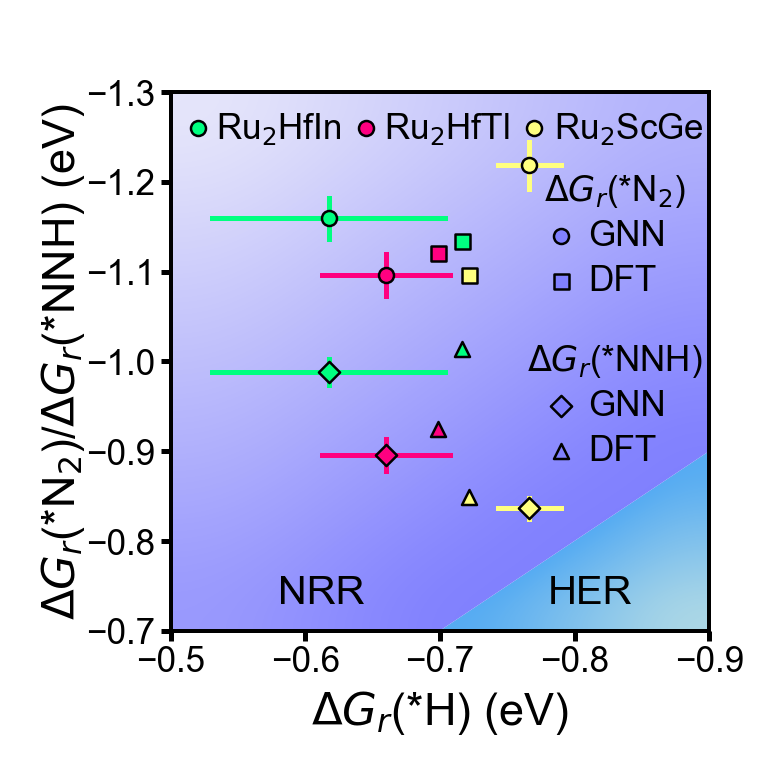

In [19]:
plt.rc('font',family='Arial')
fig=plt.figure(figsize=(5/2.54,5/2.54),dpi=360)

ax0=fig.add_axes([0,0,1,1])
ax0.set_xlim(0,1);ax0.set_ylim(0,1);ax0.set_xticks([]);ax0.set_yticks([]);ax0.axis('off')
ax0.patch.set_alpha(0.0)

s=9
lw=0.5
lwu=1
ue=0.03

ax1=fig.add_axes([0.19,0.16,0.76,0.76])
ax1.tick_params(length=2,width=1,labelsize=7,pad=1)

ax1.set_xlabel('$\Delta G_r$(*H) (eV)',fontsize=9,labelpad=2)
ax1.set_ylabel('$\Delta G_r$(*N$_2$)/$\Delta G_r$(*NNH) (eV)',fontsize=9,labelpad=0)
ax1.scatter(dfv.at['Ru2HfIn','H'],dfv.at['Ru2HfIn','N2'],s=s,marker='s',lw=lw,ec='k',c='#00ff80',zorder=10)
ax1.scatter(dfv.at['Ru2HfTl','H'],dfv.at['Ru2HfTl','N2'],s=s,marker='s',lw=lw,ec='k',c='#ff0080',zorder=10)
ax1.scatter(dfv.at['Ru2ScGe','H'],dfv.at['Ru2ScGe','N2'],s=s,marker='s',lw=lw,ec='k',c='#ffff80',zorder=10)

ax1.scatter(df.at['Ru2HfIn','H'],df.at['Ru2HfIn','N2'],s=s,marker='o',lw=lw,ec='k',c='#00ff80',zorder=10)
uqH=dfp.at[dfa.at['Ru2HfIn','H'],'uq'];uqN=dfp.at[dfa.at['Ru2HfIn','N2'],'uq']
ax1.plot([df.at['Ru2HfIn','H']-uqH,df.at['Ru2HfIn','H']+uqH],[df.at['Ru2HfIn','N2'],df.at['Ru2HfIn','N2']],lw=lwu,c='#00ff80')
ax1.plot([df.at['Ru2HfIn','H'],df.at['Ru2HfIn','H']],[df.at['Ru2HfIn','N2']-uqN,df.at['Ru2HfIn','N2']+uqN],lw=lwu,c='#00ff80')

ax1.scatter(df.at['Ru2HfTl','H'],df.at['Ru2HfTl','N2'],s=s,marker='o',lw=lw,ec='k',c='#ff0080',zorder=10)
uqH=dfp.at[dfa.at['Ru2HfTl','H'],'uq'];uqN=dfp.at[dfa.at['Ru2HfIn','N2'],'uq']
ax1.plot([df.at['Ru2HfTl','H']-uqH,df.at['Ru2HfTl','H']+uqH],[df.at['Ru2HfTl','N2'],df.at['Ru2HfTl','N2']],lw=lwu,c='#ff0080')
ax1.plot([df.at['Ru2HfTl','H'],df.at['Ru2HfTl','H']],[df.at['Ru2HfTl','N2']-uqN,df.at['Ru2HfTl','N2']+uqN],lw=lwu,c='#ff0080')

ax1.scatter(df.at['Ru2ScGe','H'],df.at['Ru2ScGe','N2'],s=s,marker='o',lw=lw,ec='k',c='#ffff80',zorder=10)
uqH=dfp.at[dfa.at['Ru2ScGe','H'],'uq'];uqN=dfp.at[dfa.at['Ru2ScGe','N2'],'uq']
ax1.plot([df.at['Ru2ScGe','H']-uqH,df.at['Ru2ScGe','H']+uqH],[df.at['Ru2ScGe','N2'],df.at['Ru2ScGe','N2']],lw=lwu,c='#ffff80')
ax1.plot([df.at['Ru2ScGe','H'],df.at['Ru2ScGe','H']],[df.at['Ru2ScGe','N2']-uqN,df.at['Ru2ScGe','N2']+uqN],lw=lwu,c='#ffff80')

ax1.set_xlim([-0.5,-0.9])
ax1.set_ylim([-0.7,-1.3])
# ax1.plot([-10,10],[-10,10])

ax2=ax1.twinx()
ax2.set_yticks([])
# ax2.set_ylabel('$\Delta$G(NNH) (eV)',fontsize=9,labelpad=0)
ax2.tick_params(length=2,width=1,labelsize=7,pad=1)
ax2.scatter(dfv.at['Ru2HfIn','H'],dfv.at['Ru2HfIn','NNH'],s=s,marker='^',lw=lw,ec='k',c='#00ff80',zorder=10)
ax2.scatter(dfv.at['Ru2HfTl','H'],dfv.at['Ru2HfTl','NNH'],s=s,marker='^',lw=lw,ec='k',c='#ff0080',zorder=10)
ax2.scatter(dfv.at['Ru2ScGe','H'],dfv.at['Ru2ScGe','NNH'],s=s,marker='^',lw=lw,ec='k',c='#ffff80',zorder=10)

ax2.scatter(df.at['Ru2HfIn','H'],df.at['Ru2HfIn','NNH'],s=s,marker='D',lw=lw,ec='k',c='#00ff80',zorder=10)
uqH=dfp.at[dfa.at['Ru2HfIn','H'],'uq'];uqN=dfp.at[dfa.at['Ru2HfIn','NNH'],'uq']
ax2.plot([df.at['Ru2HfIn','H']-uqH,df.at['Ru2HfIn','H']+uqH],[df.at['Ru2HfIn','NNH'],df.at['Ru2HfIn','NNH']],lw=lwu,c='#00ff80')
ax2.plot([df.at['Ru2HfIn','H'],df.at['Ru2HfIn','H']],[df.at['Ru2HfIn','NNH']-uqN,df.at['Ru2HfIn','NNH']+uqN],lw=lwu,c='#00ff80')

ax2.scatter(df.at['Ru2HfTl','H'],df.at['Ru2HfTl','NNH'],s=s,marker='D',lw=lw,ec='k',c='#ff0080',zorder=10)
uqH=dfp.at[dfa.at['Ru2HfTl','H'],'uq'];uqN=dfp.at[dfa.at['Ru2HfTl','NNH'],'uq']
ax2.plot([df.at['Ru2HfTl','H']-uqH,df.at['Ru2HfTl','H']+uqH],[df.at['Ru2HfTl','NNH'],df.at['Ru2HfTl','NNH']],lw=lwu,c='#ff0080')
ax2.plot([df.at['Ru2HfTl','H'],df.at['Ru2HfTl','H']],[df.at['Ru2HfTl','NNH']-uqN,df.at['Ru2HfTl','NNH']+uqN],lw=lwu,c='#ff0080')

ax2.scatter(df.at['Ru2ScGe','H'],df.at['Ru2ScGe','NNH'],s=s,marker='D',lw=lw,ec='k',c='#ffff80',zorder=10)
uqH=dfp.at[dfa.at['Ru2ScGe','H'],'uq'];uqN=dfp.at[dfa.at['Ru2ScGe','NNH'],'uq']
ax2.plot([df.at['Ru2ScGe','H']-uqH,df.at['Ru2ScGe','H']+uqH],[df.at['Ru2ScGe','NNH'],df.at['Ru2ScGe','NNH']],lw=lwu,c='#ffff80')
ax2.plot([df.at['Ru2ScGe','H'],df.at['Ru2ScGe','H']],[df.at['Ru2ScGe','NNH']-uqN,df.at['Ru2ScGe','NNH']+uqN],lw=lwu,c='#ffff80')

ax2.set_ylim([-0.7,-1.3])

Gradient_Graphics6(ax1,[-0.7,-0.9,-0.9],[-0.7,-0.7,-0.9],['k',0],[(0,'lightblue'),(1,'#0080ff')],
                   [[0.7,0.8,0.9,1.0],
                    [0.6,0.7,0.8,0.9],
                    [0.5,0.6,0.7,0.8],
                    [0.4,0.5,0.6,0.7]],True,1,0)

Gradient_Graphics6(ax1,[-0.5,-0.7,-0.9,-0.9,-0.5],[-0.7,-0.7,-0.9,-1.3,-1.3],['k',0],
                   [(0,'lavender'),(1,'#8080ff')],[[0.6,0.5,0.4,0.3,0.2],
                                            [0.7,0.6,0.5,0.4,0.3],
                                            [0.8,0.7,0.6,0.5,0.4],
                                            [0.9,0.8,0.7,0.6,0.5],
                                            [1.0,0.9,0.8,0.7,0.6],
                                            [1.0,1.0,0.9,0.8,0.7],
                                            [1.0,1.0,1.0,0.9,0.8]],True,1,0)

ax1.text(-0.58,-0.73,'NRR',fontsize=8)
ax1.text(-0.78,-0.73,'HER',fontsize=8)

ax1.scatter(-0.52,-1.26,s=s,marker='o',lw=lw,ec='k',c='#00ff80',zorder=10)
ax1.text(-0.58,-1.26,'Ru$_2$HfIn',ha='center',va='center',fontsize=7)
ax1.scatter(-0.645,-1.26,s=s,marker='o',lw=lw,ec='k',c='#ff0080',zorder=10)
ax1.text(-0.705,-1.26,'Ru$_2$HfTl',ha='center',va='center',fontsize=7)
ax1.scatter(-0.77,-1.26,s=s,marker='o',lw=lw,ec='k',c='#ffff80',zorder=10)
ax1.text(-0.84,-1.26,'Ru$_2$ScGe',ha='center',va='center',fontsize=7)

ax1.text(-0.83,-1.19,'$\Delta G_r$(*N$_2$)',fontsize=7,ha='center',va='center')
ax1.scatter(-0.79,-1.14,s=s,marker='o',lw=lw,ec='k',c='#8080ff',zorder=10)
ax1.text(-0.81,-1.14,'GNN',fontsize=7,ha='left',va='center')
ax1.scatter(-0.79,-1.09,s=s,marker='s',lw=lw,ec='k',c='#8080ff',zorder=10)
ax1.text(-0.81,-1.09,'DFT',fontsize=7,ha='left',va='center')

ax1.text(-0.83,-1.,'$\Delta G_r$(*NNH)',fontsize=7,ha='center',va='center')
ax1.scatter(-0.79,-0.95,s=s,marker='D',lw=lw,ec='k',c='#8080ff',zorder=10)
ax1.text(-0.81,-0.95,'GNN',fontsize=7,ha='left',va='center')
ax1.scatter(-0.79,-0.9,s=s,marker='^',lw=lw,ec='k',c='#8080ff',zorder=10)
ax1.text(-0.81,-0.9,'DFT',fontsize=7,ha='left',va='center')


# fig.savefig('Figure_5_c.tif',dpi=360)

# Figure 5d

Text(10, -0.56, 'PDS by GNN')

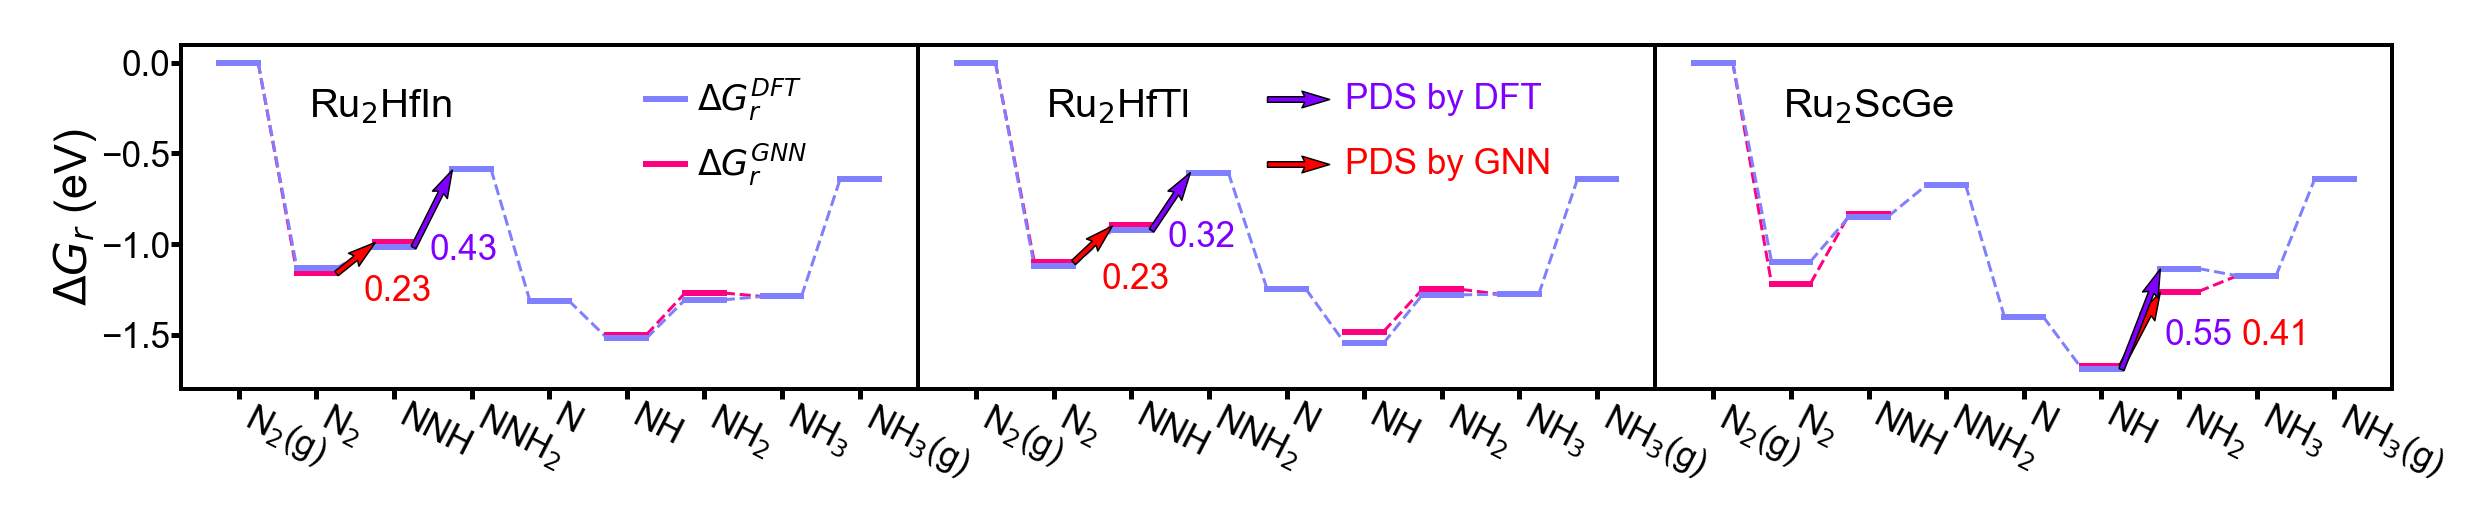

In [26]:
plt.rc('font',family='Arial')
fig=plt.figure(figsize=(17/2.54,3.2/2.54),dpi=360)

ax0=fig.add_axes([0,0,1,1])
ax0.set_xlim(0,1);ax0.set_ylim(0,1);ax0.set_xticks([]);ax0.set_yticks([]);ax0.axis('off')
ax0.patch.set_alpha(0.0)

ax1=fig.add_axes([0.06,0.22,0.306,0.76])
ax1.tick_params(length=2,width=1,labelsize=7,pad=0)
ax1.set_ylabel('$\Delta G_r$ (eV)',fontsize=9,labelpad=0.5)
c_distal='#8080ff'
c_gnn='#ff0080'
c_alterna='#0080ff'
energy_diagram(ax1,dfv,'Ru2HfIn',[
    [[('N2v',c_gnn),('N2',c_distal)],[[(0,c_gnn)],[(0,c_distal)]]],
    [[('NNHv',c_gnn),('NNH',c_distal)],[[(0,c_gnn)],[(1,c_distal)]]],
    [[('NNH2',c_distal)],[[(1,c_distal)]]],
    [[('N',c_distal)],[[(0,c_distal)]]],
    [[('NHv',c_gnn),('NH',c_distal)],[[],[(0,c_distal)]]],
    [[('NH2v',c_gnn),('NH2',c_distal)],[[(0,c_gnn)],[(1,c_distal)]]],
    [[('NH3',c_distal)],[[(0,c_gnn),(1,c_distal)]]],
    [[('NH3(g)',c_distal)],[[(0,c_distal)]]]
],xtickpara=['N$_2$(g)',7,-27,'left',['N2v','NNHv','NHv','NH2v']],xylim=[-1,18,-1.8,0.1],interval=1,first_color='#8080ff')
sys='Ru2HfIn'
# ax1.errorbar([2.5,4.5,10.5,12.5],[df.at[sys,adsb] for adsb in ['N2','NNH','NH','NH2']],
#             yerr=[dfp.at[dfa.at[sys,adsb],'uq'] for adsb in ['N2','NNH','NH','NH2']],
#             elinewidth=0.3,capsize=2,zorder=1,capthick=0.3,barsabove=True,lw=0,c='#00ff80',ecolor='darkred')
ax1.quiver(5,dfv.at[sys,'NNH'],1,dfv.at[sys,'NNH2']-dfv.at[sys,'NNH'],lw=0.3,fc='#8000ff', ec='k',zorder=200,angles='xy', scale_units='xy', scale=1)
ax1.quiver(3,df.at[sys,'N2'],1,df.at[sys,'NNH']-df.at[sys,'N2'],lw=0.3,fc='r', ec='k',zorder=199,angles='xy', scale_units='xy', scale=1)
ax1.text(6.3,-1.03,'0.43',fontsize=7,c='#8000ff',ha='center',va='center')
ax1.text(4.6,-1.26,'0.23',fontsize=7,c='r',ha='center',va='center')
ax1.text(2.3,-0.3,'Ru$_2$HfIn',fontsize=8,c='k')

ax2=fig.add_axes([0.366,0.22,0.306,0.76])
ax2.tick_params(length=2,width=1,labelsize=7,pad=0)
ax2.set_yticks([])
energy_diagram(ax2,dfv,'Ru2HfTl',[
    [[('N2v',c_gnn),('N2',c_distal)],[[(0,c_gnn)],[(0,c_distal)]]],
    [[('NNHv',c_gnn),('NNH',c_distal)],[[(0,c_gnn)],[(1,c_distal)]]],
    [[('NNH2',c_distal)],[[(1,c_distal)]]],
    [[('N',c_distal)],[[(0,c_distal)]]],
    [[('NHv',c_gnn),('NH',c_distal)],[[],[(0,c_distal)]]],
    [[('NH2v',c_gnn),('NH2',c_distal)],[[(0,c_gnn)],[(1,c_distal)]]],
    [[('NH3',c_distal)],[[(0,c_gnn),(1,c_distal)]]],
    [[('NH3(g)',c_distal)],[[(0,c_distal)]]]
],xtickpara=['N$_2$(g)',7,-27,'left',['N2v','NNHv','NHv','NH2v']],xylim=[-1,18,-1.8,0.1],interval=1.,first_color='#8080ff')
sys='Ru2HfTl'
# ax2.errorbar([2.5,4.5,10.5,12.5],[df.at[sys,adsb] for adsb in ['N2','NNH','NH','NH2']],
#             yerr=[dfp.at[dfa.at[sys,adsb],'uq'] for adsb in ['N2','NNH','NH','NH2']],
#             elinewidth=0.3,capsize=2,zorder=1,capthick=0.3,barsabove=True,lw=0,c='#00ff80',ecolor='darkred')
ax2.quiver(5,dfv.at[sys,'NNH'],1,dfv.at[sys,'NNH2']-dfv.at[sys,'NNH'],lw=0.3,fc='#8000ff', ec='k',zorder=200,angles='xy', scale_units='xy', scale=1)
ax2.quiver(3,df.at[sys,'N2'],1,df.at[sys,'NNH']-df.at[sys,'N2'],lw=0.3,fc='r', ec='k',zorder=199,angles='xy', scale_units='xy', scale=1)
ax2.text(6.3,-0.96,'0.32',fontsize=7,c='#8000ff',ha='center',va='center')
ax2.text(4.6,-1.19,'0.23',fontsize=7,c='r',ha='center',va='center')
ax2.text(2.3,-0.3,'Ru$_2$HfTl',fontsize=8,c='k')


ax3=fig.add_axes([0.672,0.22,0.306,0.76])
ax3.tick_params(length=2,width=1,labelsize=7,pad=0)
ax3.set_yticks([])
energy_diagram(ax3,dfv,'Ru2ScGe',[
    [[('N2v',c_gnn),('N2',c_distal)],[[(0,c_gnn)],[(0,c_distal)]]],
    [[('NNHv',c_gnn),('NNH',c_distal)],[[(0,c_gnn)],[(1,c_distal)]]],
    [[('NNH2',c_distal)],[[(1,c_distal)]]],
    [[('N',c_distal)],[[(0,c_distal)]]],
    [[('NHv',c_gnn),('NH',c_distal)],[[],[(0,c_distal)]]],
    [[('NH2v',c_gnn),('NH2',c_distal)],[[(0,c_gnn)],[(1,c_distal)]]],
    [[('NH3',c_distal)],[[(0,c_gnn),(1,c_distal)]]],
    [[('NH3(g)',c_distal)],[[(0,c_distal)]]]
],xtickpara=['N$_2$(g)',7,-27,'left',['N2v','NNHv','NHv','NH2v']],xylim=[-1,18,-1.8,0.1],interval=1.,first_color=c_distal)
sys='Ru2ScGe'
# ax3.errorbar([2.5,4.5,10.5,12.5],[df.at[sys,adsb] for adsb in ['N2','NNH','NH','NH2']],
#             yerr=[dfp.at[dfa.at[sys,adsb],'uq'] for adsb in ['N2','NNH','NH','NH2']],
#             elinewidth=0.3,capsize=2,zorder=1,capthick=0.3,barsabove=True,lw=0,c='#00ff80',ecolor='darkred')
ax3.quiver(11,dfv.at[sys,'NH'],1,dfv.at[sys,'NH2']-dfv.at[sys,'NH'],lw=0.3,fc='#8000ff', ec='k',zorder=200,angles='xy', scale_units='xy', scale=1)
ax3.quiver(11,df.at[sys,'NH']-0.31955,1,df.at[sys,'NH2']-df.at[sys,'NH'],lw=0.3,fc='r', ec='k',zorder=199,angles='xy', scale_units='xy', scale=1)
ax3.text(13,-1.5,'0.55',fontsize=7,c='#8000ff',ha='center',va='center')
ax3.text(15,-1.5,'0.41',fontsize=7,c='r',ha='center',va='center')
ax3.text(2.3,-0.3,'Ru$_2$ScGe',fontsize=8,c='k')

ax1.plot([11,12],[-0.2,-0.2],lw=1.2,ls='-',c=c_distal)
ax1.text(12.3,-0.2,'$\Delta G_r^{DFT}$',fontsize=7,ha='left',va='center')
ax1.plot([11,12],[-0.56,-0.56],lw=1.2,ls='-',c=c_gnn)
ax1.text(12.3,-0.56,'$\Delta G_r^{GNN}$',fontsize=7,ha='left',va='center')

ax2.quiver(8,-0.2,1.6,0,lw=0.3,fc='#8000ff', ec='k',zorder=200,angles='xy', scale_units='xy', scale=1)
ax2.quiver(8,-0.56,1.6,0,lw=0.3,fc='r', ec='k',zorder=0,angles='xy', scale_units='xy', scale=1)
ax2.text(10,-0.2,'PDS by DFT',fontsize=7,c='#8000ff',ha='left',va='center')
ax2.text(10,-0.56,'PDS by GNN',fontsize=7,c='r',ha='left',va='center')

# fig.savefig('Figure_5_d.tif',dpi=360)

## old version

Text(10, -0.56, 'PDS by GNN')

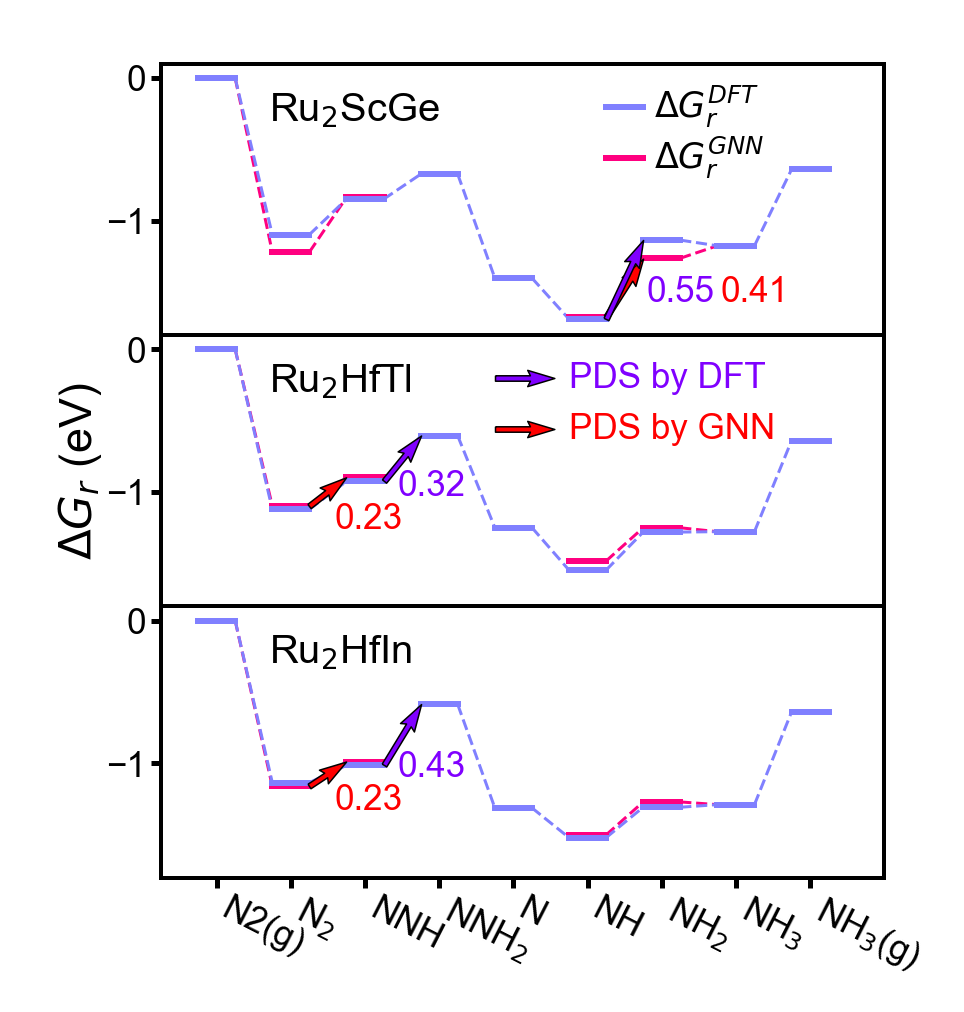

In [27]:
plt.rc('font',family='Arial')
fig=plt.figure(figsize=(6.3/2.54,6.6/2.54),dpi=360)

ax0=fig.add_axes([0,0,1,1])
ax0.set_xlim(0,1);ax0.set_ylim(0,1);ax0.set_xticks([]);ax0.set_yticks([]);ax0.axis('off')
ax0.patch.set_alpha(0.0)

ax1=fig.add_axes([0.14,0.1,0.81,0.29])
ax1.tick_params(length=2,width=1,labelsize=7,pad=1)
c_distal='#8080ff'
c_gnn='#ff0080'
c_alterna='#0080ff'
energy_diagram(ax1,dfv,'Ru2HfIn',[
    [[('N2v',c_gnn),('N2',c_distal)],[[(0,c_gnn)],[(0,c_distal)]]],
    [[('NNHv',c_gnn),('NNH',c_distal)],[[(0,c_gnn)],[(1,c_distal)]]],
    [[('NNH2',c_distal)],[[(1,c_distal)]]],
    [[('N',c_distal)],[[(0,c_distal)]]],
    [[('NHv',c_gnn),('NH',c_distal)],[[],[(0,c_distal)]]],
    [[('NH2v',c_gnn),('NH2',c_distal)],[[(0,c_gnn)],[(1,c_distal)]]],
    [[('NH3',c_distal)],[[(0,c_gnn),(1,c_distal)]]],
    [[('NH3(g)',c_distal)],[[(0,c_distal)]]]
],xtickpara=['N2(g)',7,-27,'left',['N2v','NNHv','NHv','NH2v']],xylim=[-1,18.5,-1.8,0.1],interval=1,first_color='#8080ff')
sys='Ru2HfIn'
# ax1.errorbar([2.5,4.5,10.5,12.5],[df.at[sys,adsb] for adsb in ['N2','NNH','NH','NH2']],
#             yerr=[dfp.at[dfa.at[sys,adsb],'uq'] for adsb in ['N2','NNH','NH','NH2']],
#             elinewidth=0.3,capsize=2,zorder=1,capthick=0.3,barsabove=True,lw=0,c='#00ff80',ecolor='darkred')
ax1.quiver(5,dfv.at[sys,'NNH'],1,dfv.at[sys,'NNH2']-dfv.at[sys,'NNH'],lw=0.3,fc='#8000ff', ec='k',zorder=200,angles='xy', scale_units='xy', scale=1)
ax1.quiver(3,df.at[sys,'N2'],1,df.at[sys,'NNH']-df.at[sys,'N2'],lw=0.3,fc='r', ec='k',zorder=199,angles='xy', scale_units='xy', scale=1)
ax1.text(6.3,-1.03,'0.43',fontsize=7,c='#8000ff',ha='center',va='center')
ax1.text(4.6,-1.26,'0.23',fontsize=7,c='r',ha='center',va='center')
ax1.text(1.9,-0.3,'Ru$_2$HfIn',fontsize=8,c='k')

ax2=fig.add_axes([0.14,0.39,0.81,0.29])
ax2.tick_params(length=2,width=1,labelsize=7,pad=1)
ax2.set_ylabel('$\Delta G_r$ (eV)',fontsize=9,labelpad=0.5)
ax2.set_xticks([])
energy_diagram(ax2,dfv,'Ru2HfTl',[
    [[('N2v',c_gnn),('N2',c_distal)],[[(0,c_gnn)],[(0,c_distal)]]],
    [[('NNHv',c_gnn),('NNH',c_distal)],[[(0,c_gnn)],[(1,c_distal)]]],
    [[('NNH2',c_distal)],[[(1,c_distal)]]],
    [[('N',c_distal)],[[(0,c_distal)]]],
    [[('NHv',c_gnn),('NH',c_distal)],[[],[(0,c_distal)]]],
    [[('NH2v',c_gnn),('NH2',c_distal)],[[(0,c_gnn)],[(1,c_distal)]]],
    [[('NH3',c_distal)],[[(0,c_gnn),(1,c_distal)]]],
    [[('NH3(g)',c_distal)],[[(0,c_distal)]]]
],xtickpara=None,xylim=[-1,18.5,-1.8,0.1],interval=1.,first_color='#8080ff')
sys='Ru2HfTl'
# ax2.errorbar([2.5,4.5,10.5,12.5],[df.at[sys,adsb] for adsb in ['N2','NNH','NH','NH2']],
#             yerr=[dfp.at[dfa.at[sys,adsb],'uq'] for adsb in ['N2','NNH','NH','NH2']],
#             elinewidth=0.3,capsize=2,zorder=1,capthick=0.3,barsabove=True,lw=0,c='#00ff80',ecolor='darkred')
ax2.quiver(5,dfv.at[sys,'NNH'],1,dfv.at[sys,'NNH2']-dfv.at[sys,'NNH'],lw=0.3,fc='#8000ff', ec='k',zorder=200,angles='xy', scale_units='xy', scale=1)
ax2.quiver(3,df.at[sys,'N2'],1,df.at[sys,'NNH']-df.at[sys,'N2'],lw=0.3,fc='r', ec='k',zorder=199,angles='xy', scale_units='xy', scale=1)
ax2.text(6.3,-0.96,'0.32',fontsize=7,c='#8000ff',ha='center',va='center')
ax2.text(4.6,-1.19,'0.23',fontsize=7,c='r',ha='center',va='center')
ax2.text(1.9,-0.3,'Ru$_2$HfTl',fontsize=8,c='k')


ax3=fig.add_axes([0.14,0.68,0.81,0.29])
ax3.tick_params(length=2,width=1,labelsize=7,pad=1)
ax3.set_xticks([])
energy_diagram(ax3,dfv,'Ru2ScGe',[
    [[('N2v',c_gnn),('N2',c_distal)],[[(0,c_gnn)],[(0,c_distal)]]],
    [[('NNHv',c_gnn),('NNH',c_distal)],[[(0,c_gnn)],[(1,c_distal)]]],
    [[('NNH2',c_distal)],[[(1,c_distal)]]],
    [[('N',c_distal)],[[(0,c_distal)]]],
    [[('NHv',c_gnn),('NH',c_distal)],[[],[(0,c_distal)]]],
    [[('NH2v',c_gnn),('NH2',c_distal)],[[(0,c_gnn)],[(1,c_distal)]]],
    [[('NH3',c_distal)],[[(0,c_gnn),(1,c_distal)]]],
    [[('NH3(g)',c_distal)],[[(0,c_distal)]]]
],xtickpara=None,xylim=[-1,18.5,-1.8,0.1],interval=1.,first_color=c_distal)
sys='Ru2ScGe'
# ax3.errorbar([2.5,4.5,10.5,12.5],[df.at[sys,adsb] for adsb in ['N2','NNH','NH','NH2']],
#             yerr=[dfp.at[dfa.at[sys,adsb],'uq'] for adsb in ['N2','NNH','NH','NH2']],
#             elinewidth=0.3,capsize=2,zorder=1,capthick=0.3,barsabove=True,lw=0,c='#00ff80',ecolor='darkred')
ax3.quiver(11,dfv.at[sys,'NH'],1,dfv.at[sys,'NH2']-dfv.at[sys,'NH'],lw=0.3,fc='#8000ff', ec='k',zorder=200,angles='xy', scale_units='xy', scale=1)
ax3.quiver(11,df.at[sys,'NH']-0.31955,1,df.at[sys,'NH2']-df.at[sys,'NH'],lw=0.3,fc='r', ec='k',zorder=199,angles='xy', scale_units='xy', scale=1)
ax3.text(13,-1.5,'0.55',fontsize=7,c='#8000ff',ha='center',va='center')
ax3.text(15,-1.5,'0.41',fontsize=7,c='r',ha='center',va='center')
ax3.text(1.9,-0.3,'Ru$_2$ScGe',fontsize=8,c='k')

ax3.plot([11,12],[-0.2,-0.2],lw=1.2,ls='-',c=c_distal)
ax3.text(12.3,-0.2,'$\Delta G_r^{DFT}$',fontsize=7,ha='left',va='center')
ax3.plot([11,12],[-0.56,-0.56],lw=1.2,ls='-',c=c_gnn)
ax3.text(12.3,-0.56,'$\Delta G_r^{GNN}$',fontsize=7,ha='left',va='center')

ax2.quiver(8,-0.2,1.6,0,lw=0.3,fc='#8000ff', ec='k',zorder=200,angles='xy', scale_units='xy', scale=1)
ax2.quiver(8,-0.56,1.6,0,lw=0.3,fc='r', ec='k',zorder=0,angles='xy', scale_units='xy', scale=1)

ax2.text(10,-0.2,'PDS by DFT',fontsize=7,c='#8000ff',ha='left',va='center')
ax2.text(10,-0.56,'PDS by GNN',fontsize=7,c='r',ha='left',va='center')

# fig.savefig('Figure_5_d.tif',dpi=360)

# Figure 5e

In [2]:
s=Structure.from_file(r'Ru2HfTl_adss\Ru2HfTl_H_0_1c.vasp')

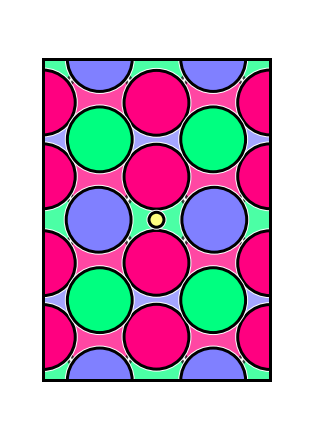

In [3]:
plt.rc('font',family='Arial')
fig=plt.figure(figsize=(1.7/2.54,2.6/2.54),dpi=360)

ax0=fig.add_axes([0,0,1,1])
ax0.set_xlim(0,1);ax0.set_ylim(0,1);ax0.set_xticks([]);ax0.set_yticks([]);ax0.axis('off')
ax0.patch.set_alpha(0.0)

# ax1=fig.add_axes([0.03,0.03,0.94,0.94])
# ax1.axis('off')

X='Ru'
Y='Hf'
Z='Tl'
plot_slab(ax0,s,max_z_cart=13.5,axis_extend=1.06,atom_edge_para=['k',0.6],cell_edge_para=['k','-',0.6,1],
         color_dict={X:'#ff0080',Y:'#8080ff',Z:'#00ff80','N':'#0080ff','H':'#ffff80'},
         radius_dict={X:1.3,Y:1.3,Z:1.3,'N':0.6,'H':0.3},)

# fig.savefig('Figure_5_Ru2HfTl_xx.tif',dpi=360)